# (N)on-(E)uclidean (U)pgrading
---
#### Description of NEU:
The NEU meta-algorithm learns a geometry for the input and (input $\times$ output) spaces by deforming them with a universal class of homeomorphisms + robustifies the involved loss functions to improve generalizability of the new and very flexible model.  
$$
\begin{aligned}
f \mapsto& \, \rho \circ f \circ \phi\\
\mathbb{E}_{\mathbb{P}}[\ell(f(X))] \mapsto & \,\max_{\mathbb{Q}\sim \mathbb{P}}\, \mathbb{E}_{\mathbb{Q}}[\ell(\rho(\phi(X), f\circ \phi(X)))].
\end{aligned}
$$
$\rho=\pi\circ \tilde{\rho}$, and $\tilde{\rho}$ and $\phi$ are "universal homeomorphisms" on $\operatorname{dom}(f)$ and on $\operatorname{dom}(f)\times \operatorname{co-dom}(f)$, respectively.  

---

---

#### Description of regression problem: 
In this notebook we implement the regression problem
$$
\begin{aligned}
y_i =&  \,f(x_i)\delta_i + \epsilon_i, \qquad i=1,\dots,N\\
\epsilon_i \sim &\, \mathcal{N}(0,\sigma),\\
\delta_i\sim &  \,U(1-D,1+D),
\end{aligned}
$$
for some *variance* $\sigma>0$ and *degree of model misspecification level* $0<D<1$.  
The quantity $\epsilon$ can be understood as, classical, additive noise while the quantity $\delta$ represents multiplicative noise.

---

---

### Functions from the paper:
 - 1) $\min\{\exp(\frac{-1}{(1+x)^2}),x+\cos(x)\}$. Reason: Evaluate performance for pasted functions and general badness.
 - 2) $\cos(\exp(-x))$.  Reason: Evaluate performance for non-periodic osculations.
 - 3) $I_{(-\infty,\frac1{2})}$.  Reason: Evaluation performance on a single jump.  
 
 ---

## Initializations:

In [1]:
# Data Structuring
import numpy as np
import pandas as pd


# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy.special import expit

# Regression
from sklearn.linear_model import LinearRegression
from scipy import linalg as scila

# Tensorflow
import tensorflow as tf
import keras as K
import keras.backend as Kb
from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras.optimizers import Adam

# Operating-System Related
import os
from pathlib import Path

# Visualization
from matplotlib.pyplot import figure

# z_Misc
import time
import math

Using TensorFlow backend.


## Check/Make Paths

In [2]:
Path('./outputs/models/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Linear_Regression/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/Base_Regressor/').mkdir(parents=True, exist_ok=True)
Path('./outputs/tables/').mkdir(parents=True, exist_ok=True)
Path('./outputs/results/').mkdir(parents=True, exist_ok=True)
Path('./inputs/data/').mkdir(parents=True, exist_ok=True)

## Initialize Internal Variables/(Hyper)parameter(s)

In [3]:
#---------------------------------#
# General Formatting Parameter(s) #
#---------------------------------#
d = 1 # Dimension of X
D = 1 # Dimension of Y

#------------------------------------#
# Training/Optimization Parameter(s) #
#------------------------------------#
# Robustness Parameter
robustness_parameter = .005
# Training meta-parameters
Pre_Epochs = 200
Full_Epochs = 600

#---------------------------#
# Architecture Parameter(s) #
#---------------------------#
# 1) Base Model
#---------------#
Initial_Depth = 2
Initial_Height = 50
# 2) Feature Map
#---------------#
Feature_map_depth = 100
Feature_map_height = 20
# 3) Readout Map
#---------------#
# Reconfiguration Parameters
N_Reconfigurations = 100
# Depth & Height Per Reconfiguration
Depth_per_reconfig = 50
Height_per_reconfig = 20

#-------------------#
# Data Parameter(s) #
#-------------------#
# Test-set meta-parameters
Train_step_proportion = .75 # (i.e.: ratio of train to test-set sizes)
Extrapolation_size = .1 # (i.e.: size of test-train set domain (diameter/2))
# Train Data meta-parameters
N_data = 10**3 # (i.e.: N)
# Noise Parameters
noise_level = .5 # (i.e.: ε_i)
Distortion = .1 # (i.e.: δ_i)
# Unknown Function:
def unknown_f(x):
    return -.1*x*np.sin(x) + .1*(x**2)*np.cos(x) + .9*x*np.exp(-np.abs(x)) + .5*np.sin(4*x + 3*x**2) + .8*np.cos(7*(x**2))+ (x % .5)

### Run External/Auxiliary Notebooks

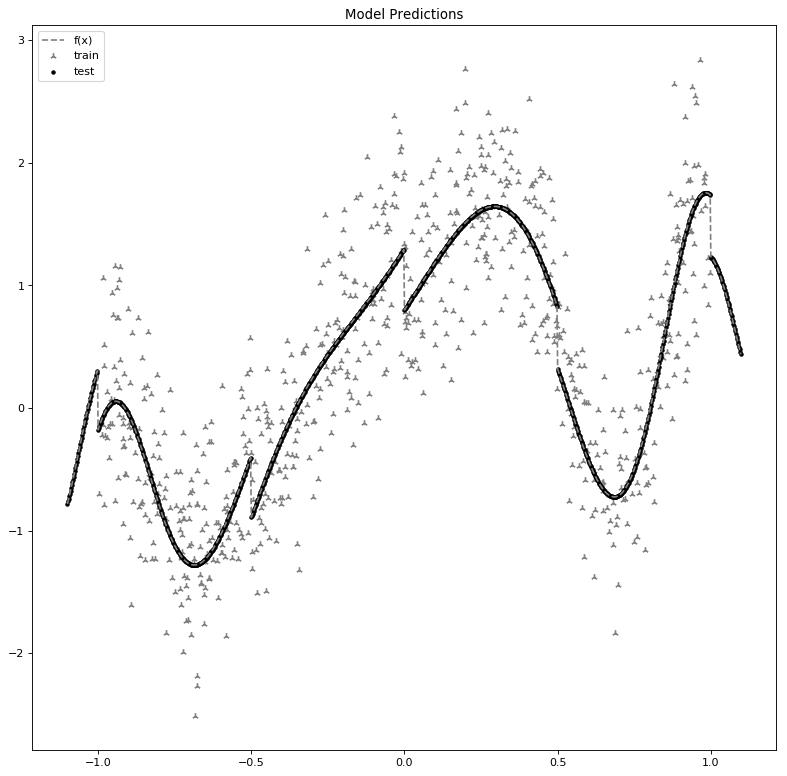

In [4]:
#------------------------#
# Run External Notebooks #
#------------------------#
# Generate Data
%run Data_Generator.ipynb
# Import Custom Layer(s)
%run Special_Layers_Homeomorphic.ipynb
# Import Utility for NEU
%run NEU_Util.ipynb
# Import Benchmarks
%run Benchmarks_Util.ipynb

#### Prepare data for NEU

## 1) Get Basic Regression Models
 1. Get Base regression model (benchmark),
 2. Get Base regression model for NEU.

## Get basic regression model - Benchmark

In [5]:
if os.path.exists('./outputs/models/Benchmarks/Linear_Regression/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Benchmark model - already exists: Loading...')
    regression_Benchmark = tf.keras.models.load_model("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_Benchmark = def_model_Regression(data_x,
                                                data_y,
                                                Pre_Epochs_in=Full_Epochs,
                                                height=(N_Reconfigurations*Height_per_reconfig),
                                                depth=Initial_Depth,
                                                learning_rate=0.01)
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Benchmark-Model: Saving')
    regression_Benchmark.save("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS_Benchmark =  regression_Benchmark.predict(data_x)
predictions_OLS_Benchmark = predictions_OLS_Benchmark.reshape(-1,)
predictions_OLS_Benchmark_test =  regression_Benchmark.predict(data_x_test)
predictions_OLS_Benchmark_test = predictions_OLS_Benchmark_test.reshape(-1,)

Benchmark model - already exists: Loading...
Benchmark model - already exists: Loaded.


## 1+2) Get base regression model for NEU + Learn optimal feature map

In [24]:
if False:#os.path.exists('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Base Regressor model - already exists: Loading...')
    regression_basic = tf.keras.models.load_model('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/', custom_objects={'Robust_MSE': Robust_MSE})
    print('Base Regressor model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_basic = get_base_model_Regression_OLS(data_x, 
                                             data_NEU, 
                                             Pre_Epochs_in=Full_Epochs, 
                                             height=Initial_Height, 
                                             depth=Initial_Depth,
                                             feature_map_depth=Feature_map_depth,
                                             feature_map_height=Feature_map_height,
                                             learning_rate=0.01)
    
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Base Regressor-Model: Saving')
    regression_basic.save("./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/")
    print('Base Regressor-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS = regression_basic.predict(data_x)
predictions_OLS = predictions_OLS.reshape(-1,)
predictions_OLS_test = regression_basic.predict(data_x_test)

Pre-trained benchmark model does not exist: Training.
Epoch 1/600
24/24 - 0s - loss: 0.4523 - mse: 0.5883 - mae: 0.4504 - mape: 108.2759
Epoch 2/600
24/24 - 0s - loss: 0.4334 - mse: 0.5357 - mae: 0.4317 - mape: 176.7254
Epoch 3/600
24/24 - 0s - loss: 0.4235 - mse: 0.5127 - mae: 0.4218 - mape: 192.6808
Epoch 4/600
24/24 - 0s - loss: 0.4180 - mse: 0.5034 - mae: 0.4163 - mape: 187.0871
Epoch 5/600
24/24 - 0s - loss: 0.4157 - mse: 0.5007 - mae: 0.4141 - mape: 164.2257
Epoch 6/600
24/24 - 0s - loss: 0.4146 - mse: 0.4988 - mae: 0.4129 - mape: 172.8149
Epoch 7/600
24/24 - 0s - loss: 0.4145 - mse: 0.5005 - mae: 0.4128 - mape: 173.8003
Epoch 8/600
24/24 - 0s - loss: 0.4141 - mse: 0.5004 - mae: 0.4124 - mape: 167.3948
Epoch 9/600
24/24 - 0s - loss: 0.4143 - mse: 0.5008 - mae: 0.4126 - mape: 170.3073
Epoch 10/600
24/24 - 0s - loss: 0.4148 - mse: 0.5035 - mae: 0.4131 - mape: 196.8291
Epoch 11/600
24/24 - 0s - loss: 0.4140 - mse: 0.5011 - mae: 0.4124 - mape: 173.3404
Epoch 12/600
24/24 - 0s - loss:

Epoch 98/600
24/24 - 0s - loss: 0.4143 - mse: 0.5005 - mae: 0.4126 - mape: 159.9957
Epoch 99/600
24/24 - 0s - loss: 0.4140 - mse: 0.5017 - mae: 0.4124 - mape: 164.1129
Epoch 100/600
24/24 - 0s - loss: 0.4142 - mse: 0.5018 - mae: 0.4126 - mape: 169.2032
Epoch 101/600
24/24 - 0s - loss: 0.4141 - mse: 0.5008 - mae: 0.4124 - mape: 160.9527
Epoch 102/600
24/24 - 0s - loss: 0.4141 - mse: 0.5009 - mae: 0.4124 - mape: 163.7837
Epoch 103/600
24/24 - 0s - loss: 0.4142 - mse: 0.5003 - mae: 0.4126 - mape: 159.0538
Epoch 104/600
24/24 - 0s - loss: 0.4141 - mse: 0.5017 - mae: 0.4125 - mape: 161.4358
Epoch 105/600
24/24 - 0s - loss: 0.4141 - mse: 0.5019 - mae: 0.4125 - mape: 166.2269
Epoch 106/600
24/24 - 0s - loss: 0.4142 - mse: 0.5022 - mae: 0.4125 - mape: 163.9826
Epoch 107/600
24/24 - 0s - loss: 0.4144 - mse: 0.5031 - mae: 0.4127 - mape: 168.7526
Epoch 108/600
24/24 - 0s - loss: 0.4140 - mse: 0.5014 - mae: 0.4124 - mape: 161.2881
Epoch 109/600
24/24 - 0s - loss: 0.4142 - mse: 0.5003 - mae: 0.4126

Epoch 195/600
24/24 - 0s - loss: 0.4140 - mse: 0.5023 - mae: 0.4124 - mape: 163.2156
Epoch 196/600
24/24 - 0s - loss: 0.4141 - mse: 0.5024 - mae: 0.4124 - mape: 168.0322
Epoch 197/600
24/24 - 0s - loss: 0.4140 - mse: 0.5017 - mae: 0.4124 - mape: 166.3110
Epoch 198/600
24/24 - 0s - loss: 0.4143 - mse: 0.5028 - mae: 0.4127 - mape: 180.4230
Epoch 199/600
24/24 - 0s - loss: 0.4139 - mse: 0.5013 - mae: 0.4122 - mape: 170.8086
Epoch 200/600
24/24 - 0s - loss: 0.4141 - mse: 0.5004 - mae: 0.4125 - mape: 163.1289
Epoch 201/600
24/24 - 0s - loss: 0.4144 - mse: 0.5011 - mae: 0.4128 - mape: 154.3951
Epoch 202/600
24/24 - 0s - loss: 0.4144 - mse: 0.5015 - mae: 0.4128 - mape: 157.4456
Epoch 203/600
24/24 - 0s - loss: 0.4142 - mse: 0.5019 - mae: 0.4125 - mape: 174.4342
Epoch 204/600
24/24 - 0s - loss: 0.4141 - mse: 0.5024 - mae: 0.4125 - mape: 161.4763
Epoch 205/600
24/24 - 0s - loss: 0.4143 - mse: 0.5023 - mae: 0.4127 - mape: 164.8051
Epoch 206/600
24/24 - 0s - loss: 0.4145 - mse: 0.5012 - mae: 0.41

Epoch 292/600
24/24 - 0s - loss: 0.4141 - mse: 0.5006 - mae: 0.4125 - mape: 165.3270
Epoch 293/600
24/24 - 0s - loss: 0.4143 - mse: 0.5017 - mae: 0.4126 - mape: 168.9420
Epoch 294/600
24/24 - 0s - loss: 0.4142 - mse: 0.5006 - mae: 0.4126 - mape: 167.1506
Epoch 295/600
24/24 - 0s - loss: 0.4143 - mse: 0.5024 - mae: 0.4126 - mape: 169.1550
Epoch 296/600
24/24 - 0s - loss: 0.4142 - mse: 0.5015 - mae: 0.4125 - mape: 170.1741
Epoch 297/600
24/24 - 0s - loss: 0.4148 - mse: 0.5043 - mae: 0.4131 - mape: 197.1087
Epoch 298/600
24/24 - 0s - loss: 0.4141 - mse: 0.5015 - mae: 0.4124 - mape: 158.2655
Epoch 299/600
24/24 - 0s - loss: 0.4142 - mse: 0.5008 - mae: 0.4126 - mape: 164.1395
Epoch 300/600
24/24 - 0s - loss: 0.4142 - mse: 0.5014 - mae: 0.4126 - mape: 160.7396
Epoch 301/600
24/24 - 0s - loss: 0.4144 - mse: 0.5033 - mae: 0.4128 - mape: 161.8539
Epoch 302/600
24/24 - 0s - loss: 0.4145 - mse: 0.5022 - mae: 0.4129 - mape: 157.4085
Epoch 303/600
24/24 - 0s - loss: 0.4142 - mse: 0.5009 - mae: 0.41

Epoch 389/600
24/24 - 0s - loss: 0.4143 - mse: 0.5021 - mae: 0.4126 - mape: 178.5680
Epoch 390/600
24/24 - 0s - loss: 0.4142 - mse: 0.5022 - mae: 0.4125 - mape: 167.4607
Epoch 391/600
24/24 - 0s - loss: 0.4141 - mse: 0.5026 - mae: 0.4125 - mape: 164.3290
Epoch 392/600
24/24 - 0s - loss: 0.4148 - mse: 0.5018 - mae: 0.4131 - mape: 187.9449
Epoch 393/600
24/24 - 0s - loss: 0.4142 - mse: 0.5006 - mae: 0.4125 - mape: 168.3527
Epoch 394/600
24/24 - 0s - loss: 0.4144 - mse: 0.5034 - mae: 0.4127 - mape: 173.9906
Epoch 395/600
24/24 - 0s - loss: 0.4142 - mse: 0.5027 - mae: 0.4125 - mape: 170.5860
Epoch 396/600
24/24 - 0s - loss: 0.4143 - mse: 0.5020 - mae: 0.4127 - mape: 174.3152
Epoch 397/600
24/24 - 0s - loss: 0.4142 - mse: 0.5021 - mae: 0.4126 - mape: 172.6052
Epoch 398/600
24/24 - 0s - loss: 0.4143 - mse: 0.5019 - mae: 0.4126 - mape: 174.0929
Epoch 399/600
24/24 - 0s - loss: 0.4144 - mse: 0.5009 - mae: 0.4128 - mape: 174.5456
Epoch 400/600
24/24 - 0s - loss: 0.4140 - mse: 0.5008 - mae: 0.41

Epoch 486/600
24/24 - 0s - loss: 0.4141 - mse: 0.5023 - mae: 0.4125 - mape: 166.7228
Epoch 487/600
24/24 - 0s - loss: 0.4141 - mse: 0.5022 - mae: 0.4125 - mape: 164.0066
Epoch 488/600
24/24 - 0s - loss: 0.4147 - mse: 0.5018 - mae: 0.4130 - mape: 158.5902
Epoch 489/600
24/24 - 0s - loss: 0.4141 - mse: 0.5014 - mae: 0.4124 - mape: 168.8389
Epoch 490/600
24/24 - 0s - loss: 0.4141 - mse: 0.5017 - mae: 0.4124 - mape: 171.4737
Epoch 491/600
24/24 - 0s - loss: 0.4142 - mse: 0.5013 - mae: 0.4125 - mape: 164.8693
Epoch 492/600
24/24 - 0s - loss: 0.4143 - mse: 0.5011 - mae: 0.4126 - mape: 166.8038
Epoch 493/600
24/24 - 0s - loss: 0.4141 - mse: 0.5018 - mae: 0.4125 - mape: 166.6595
Epoch 494/600
24/24 - 0s - loss: 0.4146 - mse: 0.5033 - mae: 0.4130 - mape: 169.7409
Epoch 495/600
24/24 - 0s - loss: 0.4144 - mse: 0.5012 - mae: 0.4128 - mape: 159.3933
Epoch 496/600
24/24 - 0s - loss: 0.4144 - mse: 0.5026 - mae: 0.4128 - mape: 163.9456
Epoch 497/600
24/24 - 0s - loss: 0.4143 - mse: 0.5035 - mae: 0.41

Epoch 583/600
24/24 - 0s - loss: 0.4145 - mse: 0.5020 - mae: 0.4129 - mape: 181.1226
Epoch 584/600
24/24 - 0s - loss: 0.4142 - mse: 0.5012 - mae: 0.4125 - mape: 159.8883
Epoch 585/600
24/24 - 0s - loss: 0.4141 - mse: 0.5012 - mae: 0.4125 - mape: 169.1442
Epoch 586/600
24/24 - 0s - loss: 0.4142 - mse: 0.5008 - mae: 0.4126 - mape: 162.5267
Epoch 587/600
24/24 - 0s - loss: 0.4141 - mse: 0.5014 - mae: 0.4125 - mape: 158.0364
Epoch 588/600
24/24 - 0s - loss: 0.4143 - mse: 0.5023 - mae: 0.4127 - mape: 178.6229
Epoch 589/600
24/24 - 0s - loss: 0.4145 - mse: 0.5013 - mae: 0.4129 - mape: 158.0790
Epoch 590/600
24/24 - 0s - loss: 0.4150 - mse: 0.5048 - mae: 0.4134 - mape: 195.2214
Epoch 591/600
24/24 - 0s - loss: 0.4147 - mse: 0.5036 - mae: 0.4130 - mape: 178.1608
Epoch 592/600
24/24 - 0s - loss: 0.4142 - mse: 0.5017 - mae: 0.4126 - mape: 160.4268
Epoch 593/600
24/24 - 0s - loss: 0.4142 - mse: 0.5024 - mae: 0.4126 - mape: 172.7083
Epoch 594/600
24/24 - 0s - loss: 0.4141 - mse: 0.5024 - mae: 0.41

### Generate Plots - Visualization

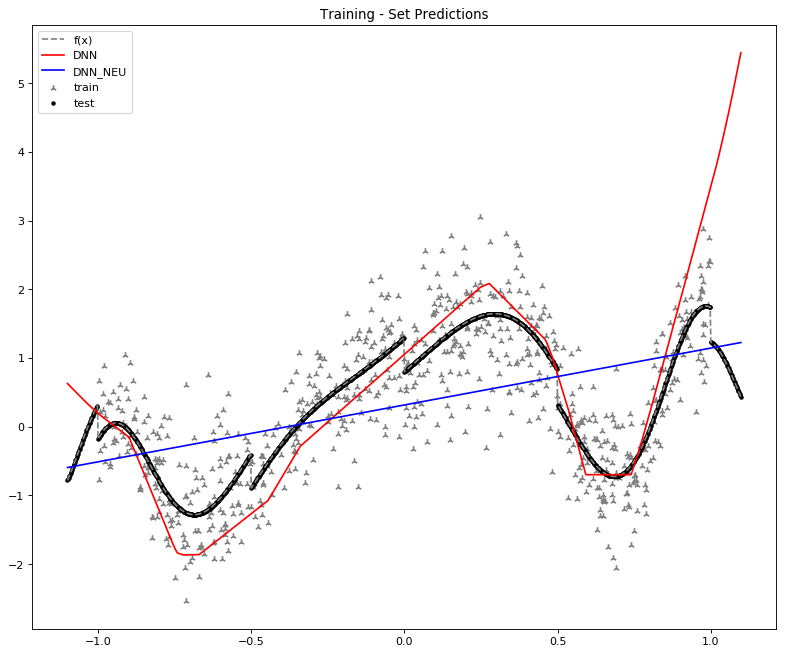

In [25]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')


# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test.reshape(-1,)), color = 'red', label='DNN')
# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='DNN_NEU')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Training - Set Predictions")
plt.show()

## 3) Readout
 1. Get Base Model,
 2. Greedy Layer-Wise Initialization,
 3. Robust SGD on entire structure.
 
We train NEU-OLS, by unfreezing the greedily initialized layers, as per [this paper](https://papers.nips.cc/paper/3048-greedy-layer-wise-training-of-deep-networks.pdf), and using "robust"-SGD on the whole structure.

In [ ]:
#----------------------------------#
# Greedy Layer-Wise Initialization #
#----------------------------------#
if os.path.exists("./outputs/models/NEU/Greedy_Initializations/saved_model.pb"):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Pre-trained readout-map already exists: Loading.')
    NEU_OLS_Greedy_init = tf.keras.models.load_model("./outputs/models/NEU/Greedy_Initializations/")
    print('Saved pre-trained readout-map: Loaded.')
    #-----------------#
    # Load Full-Model #
    #-----------------#
    print('Full-model already exists: Loading.')
    NEU_OLS = tf.keras.models.load_model("./outputs/models/NEU/", custom_objects={'Robust_MSE': Robust_MSE})
    print('Full-Model: Loaded')
else:
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                          Pre-Trained Model                                           #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('Pre-trained model does not exist: Training.')
    # Greedy Initialization
    model = regression_basic
    NEU_OLS_Greedy_init = model
    for i in range(N_Reconfigurations):
        # Update Model
        NEU_OLS_Greedy_init_temp = add_reconfiguration_unit_greedily(NEU_OLS_Greedy_init,
                                                                     data_x,
                                                                     data_NEU,
                                                                     Pre_Epochs,
                                                                     Depth_per_reconfig,
                                                                     Height_per_reconfig)

        # Check for Blowup
        if math.isnan(np.mean(NEU_OLS_Greedy_init.predict(data_x))):
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init
            break
        else: #Update Model if not explosion
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init_temp

        #-------------#
        # Update User #
        #-------------#
        print(np.mean(np.abs((NEU_OLS_Greedy_init.predict(data_x) - data_NEU)**2)))
        # Update User on Status of Initialization
        print(((i+1)/N_Reconfigurations))
        
    # Update User of Pre-Training Completion
    print('Complete: Pre-Training Readout Map on Input x Output Space!')
    
    #------------------------------------#
    # Save Greedily Initialized Layer(s) #
    #------------------------------------#
    print('Saving Pre-Trained Readout on Input x Output Space!')
    NEU_OLS_Greedy_init.save("./outputs/models/NEU/Greedy_Initializations/")
    
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                             Full Model                                               #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('(Full-)Model does not exist: Training.')
    NEU_OLS = build_reconfiguration(model_greedy_initialized=NEU_OLS_Greedy_init, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    height = Height_per_reconfig)
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Full-Model: Saving')
    NEU_OLS.save("./outputs/models/NEU/")
    print('Full-Model: Saved')
    

# Make Predictions #
#------------------#
# Predictions Train
NEU_OLS_greedy_initializations = NEU_OLS_Greedy_init.predict(data_x)
NEU_OLS_prediction = NEU_OLS.predict(data_x)
NEU_OLS_prediction = NEU_OLS_prediction.reshape(-1,)
# Predictions Test
NEU_OLS_greedy_initializations_test = NEU_OLS_Greedy_init.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS_prediction_test.reshape(-1,)

    
# Update User #
#-------------#
print('NEU: Ready!')

Pre-trained readout-map already exists: Loading.
Saved pre-trained readout-map: Loaded.
Full-model already exists: Loading.
Full-Model: Loaded


### Generate Plots - Visualization

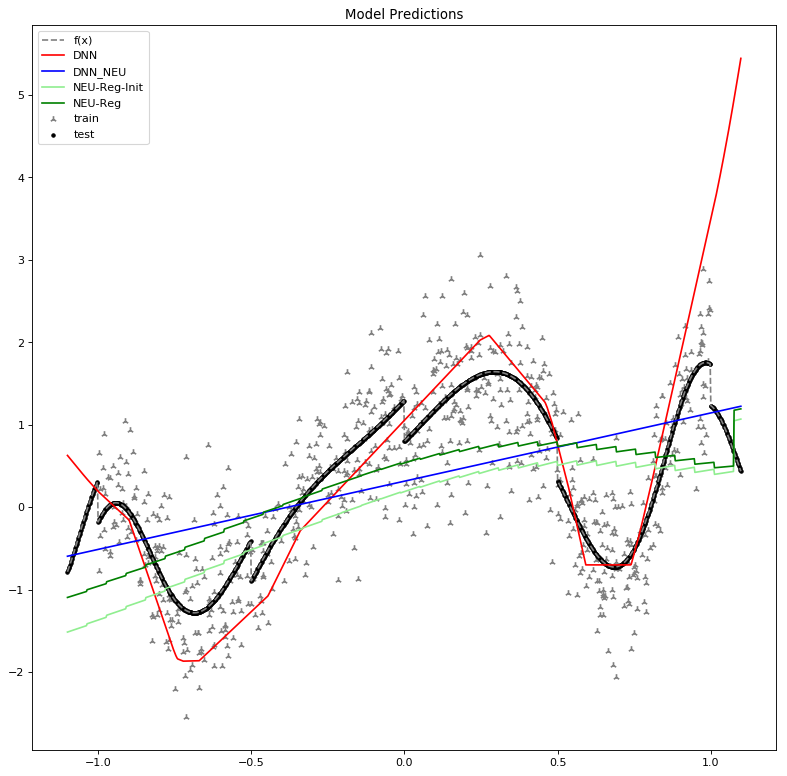

In [29]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test), color = 'red', label='DNN')


# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='DNN_NEU')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")
plt.show()

---
---
---

# Benchmark Models

In [30]:
#------------------#
# Train GLd-Model  #
#------------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/saved_model.pb"):
    print('GLd-Nets Trained model already exists: Loading.')
    Deep_GLd = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets trained model: Loaded.')
else:
    print('GLd-Nets Model does not exist: Training.')
    # Basic Model
    regression_basic_nonrobust = get_base_model_Regression_nonrobust(data_x, 
                                             data_NEU, 
                                             Pre_Epochs_in=200, 
                                             height=100, 
                                             depth=10,
                                             learning_rate=0.01)
    # NEU Version
    Deep_GLd = build_reconfiguration_GLd(model_greedy_initialized=regression_basic_nonrobust, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    depth= (Depth_per_reconfig*N_Reconfigurations))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('GLd-Nets Model: Saving')
    Deep_GLd.save("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets Model: Saved')

    
# Predictions Train
Deep_GLd_prediction = Deep_GLd.predict(data_x)
Deep_GLd_prediction = Deep_GLd_prediction.reshape(-1,)
# Predictions Test
Deep_GLd_prediction_test = Deep_GLd.predict(data_x_test)
Deep_GLd_prediction_test = Deep_GLd_prediction_test.reshape(-1,)
    
# Update User #
#-------------#
print('Benchmark Model - GLd-Nets: Ready!')

GLd-Nets Trained model already exists: Loading.
GLd-Nets trained model: Loaded.
Benchmark Model - GLd-Nets: Ready!


In [31]:
#-----------------#
# Train Ed-Model  #
#-----------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/saved_model.pb"):
    print('Ed-Nets Trained model already exists: Loading.')
    Deep_Ed = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets trained model: Loaded.')
else:
    print('Ed-Nets Model does not exist: Training.')
    Deep_Ed=build_reconfiguration_Ed(model_greedy_initialized=regression_basic_nonrobust, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    depth= (Depth_per_reconfig*N_Reconfigurations))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('Ed-Nets Model: Saving')
    Deep_Ed.save("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets Model: Saved')
    
    
# Predictions Train
Deep_Ed_prediction = Deep_Ed.predict(data_x)
Deep_Ed_prediction = Deep_Ed_prediction.reshape(-1,)
# Predictions Test
Deep_Ed_prediction_test = Deep_Ed.predict(data_x_test)
Deep_Ed_prediction_test = Deep_Ed_prediction_test.reshape(-1)
    
# Update User #
#-------------#
print('Benchmark Model - Ed-Nets: Ready!')

Ed-Nets Trained model already exists: Loading.
Ed-Nets trained model: Loaded.
Benchmark Model - Ed-Nets: Ready!


Run univariate regression benchmarks file:

In [32]:
# Run Univariate Regression File #
#--------------------------------#
%run Univariate_Regression_Benchmark_Models.ipynb

## Model Evaluation: 
*Record Error(s)/Prediction Quality*

Train results.

In [33]:
# Train Set #
#-----------#
Vanilla = get_results(predictions_OLS_Benchmark,data_y)
NEU = get_results(NEU_OLS_prediction,data_y)
NEU_Gld = get_results(Deep_GLd_prediction,data_y)
NEU_Ed = get_results(Deep_Ed_prediction,data_y)
SSplines = get_results(f_hat_smoothing_splines_train,data_y)
LOESS = get_results(LOESS_prediction_train,data_y)

# Write to DataFrame
Results = pd.DataFrame({'Vanilla': Vanilla,
                             'NEU': NEU,
                             'NEU_GLd': NEU_Gld,
                             'NEU_Ed':NEU_Ed,
                             'Smoothing_Splines':SSplines,
                             'LOESS':LOESS},index={'MAE','MinE','MaxE','MSE','rMSE'})
# Format
Results = pd.DataFrame.transpose(Results)

# Write Results to file #
#-----------------------#
Results.to_latex('./outputs/results/Performance.txt')
# Write to Txt
cur_path = os.path.expanduser('./outputs/results/Performance_text.txt')
with open(cur_path, "w") as f:
    f.write(str(Results))

Test results.

In [34]:
# Test Set #
#----------#
Vanilla = get_results(predictions_OLS_Benchmark_test,data_y_test)
NEU = get_results(NEU_OLS_prediction_test,data_y_test)
NEU_Gld = get_results(Deep_GLd_prediction_test,data_y_test)
NEU_Ed = get_results(Deep_Ed_prediction_test,data_y_test)
SSplines = get_results(f_hat_smoothing_splines_test,data_y_test)
LOESS = get_results(LOESS_prediction_test,data_y_test)

# Write to DataFrame
Results_test = pd.DataFrame({'Vanilla': Vanilla,
                             'NEU': NEU,
                             'NEU_GLd': NEU_Gld,
                             'NEU_Ed':NEU_Ed,
                             'Smoothing_Splines':SSplines,
                             'LOESS':LOESS},index={'MAE','MinE','MaxE','MSE','rMSE'})
# Format
Results_test = pd.DataFrame.transpose(Results_test)

# Write Results to file #
#-----------------------#
Results_test.to_latex('./outputs/results/Performance_test.txt')
# Write to Txt
cur_path = os.path.expanduser('./outputs/results/Performance_test_text.txt')
with open(cur_path, "w") as f:
    f.write(str(Results_test))

# Visualize Predictions

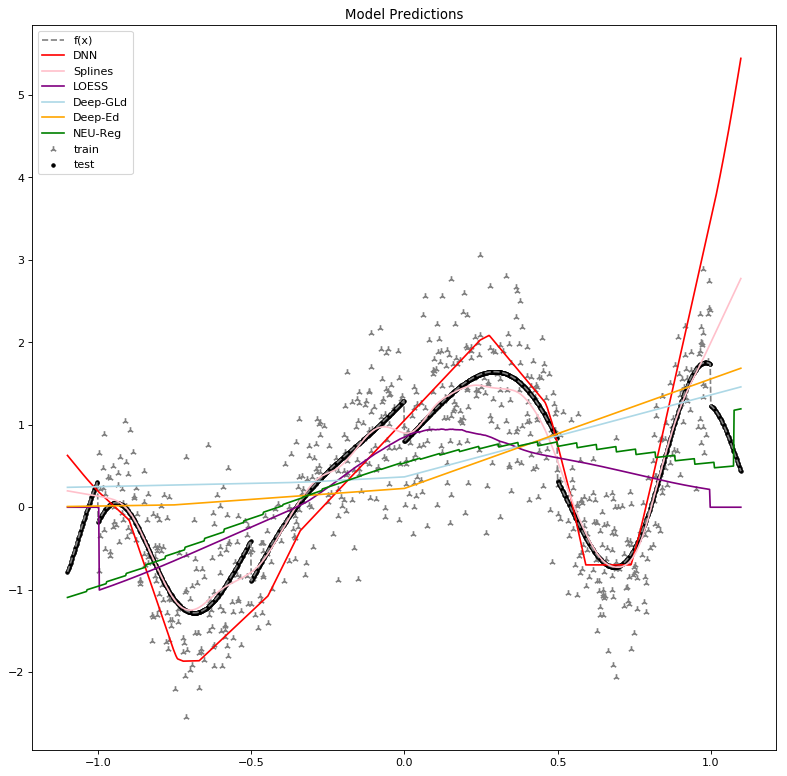

In [35]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

# Plot Benchmark(s)
#------------------#
# Standard Benchmarks
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test), color = 'red', label='DNN')
# Plot Univariate Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),f_hat_smoothing_splines_test,color='pink',label='Splines')
plt.plot(np.array(data_x_test).reshape(-1,),LOESS_prediction_test,color='purple',label='LOESS')
# NEU Benchmarks: Alternatives to reconfigurations
plt.plot(np.array(data_x_test).reshape(-1,),Deep_GLd_prediction_test,color='lightblue',label='Deep-GLd')
plt.plot(np.array(data_x_test).reshape(-1,),Deep_Ed_prediction_test,color='orange',label='Deep-Ed')

# Plot NEU Regressors
# ---------------------------------- for INDEV  only: BEGIN --------------------------------------------------- #
# plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='DNN_NEU')
# plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
# ---------------------------------- for INDEV  only: END ----------------------------------------------------- #
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")
plt.show()

 ---

# Report Results

In [36]:
print('Train Results:')
Results.style.apply(lambda col: ['font-weight:bold' if x==col.min() else '' for x in col])

Train Results:


,MaxE,MAE,rMSE,MinE,MSE
Vanilla,0.648821,0.000442,2.618406,0.672304,0.649450
NEU,0.770606,0.002817,2.781485,0.864494,0.771283
NEU_GLd,0.907528,0.000108,3.119511,1.221479,0.908524
NEU_Ed,0.896061,0.003528,3.211194,1.202702,0.897061
Smoothing_Splines,0.455842,0.000511,1.886026,0.329069,0.456145
LOESS,0.729730,0.002537,2.654853,0.790984,0.730377


In [37]:
print('Test Results:')
Results_test.style.apply(lambda col: ['font-weight:bold' if x==col.min() else '' for x in col])

Test Results:


,MaxE,MAE,rMSE,MinE,MSE
Vanilla,0.513249,0.000063,5.006850,0.793408,0.514580
NEU,0.641315,0.002855,1.458958,0.526775,0.641604
NEU_GLd,0.768981,0.002197,1.779001,0.808532,0.769524
NEU_Ed,0.750290,0.000115,1.872197,0.790289,0.750858
Smoothing_Splines,0.152788,0.000010,2.336856,0.133358,0.153063
LOESS,0.561345,0.000814,1.737681,0.444142,0.561667


#### The END

---